<center>
    <h1>QF5214 - Final Project</h1>
    <h2>Written by: SHUAI Yifan/Zhou Wanyue/Jin Zixiang/Bi Haoyu/Zilin/Jiamin</h2>
    <h3>Student ID: A0274472Y/...</h3>
    <h4>Date: 29/03/2024</h4>
</center>

<center>
<h2> Topic: Walmart Store Future Sales Forecast </h2>
</center>

## 1. Data Visualization

### 1.1 Basic Data Information

In [1]:
#pip install lightgbm

In [84]:
import sqlite3
import numpy as np
import pandas as pd
import datetime as dt
import lightgbm as lgb

#visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Time series analysis
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

# Data preprocessing
from sklearn.model_selection import train_test_split

# Grid search
from sklearn.model_selection import GridSearchCV

# Validataion
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from IPython.display import Image

In [85]:
# Load Dataset
cal = pd.read_csv('calendar.csv') #calendar data
sales_train = pd.read_csv('sales_train_validation.csv') #sales_train data
sell_price = pd.read_csv('sell_prices.csv') #sell_price data
sample = pd.read_csv('sample_submission.csv')

In [86]:
macro_data_1 = pd.read_excel('macro_raw_data.xlsx') # macro data

In [87]:
# Data Cleaning and resampling of macro data from monthly to daily frequency
macro_data_2 = macro_data_1.iloc[2:,1:]
macro_data_2.set_index(macro_data_2.columns[0],inplace = True)
daily_dates = cal.date
macro_data_daily = macro_data_2.reindex(daily_dates, method='bfill').dropna()
macro_data_daily.index =pd.to_datetime(macro_data_daily.index)

# Feature engineering on macro raw data using pct_change
macro_data_pct_change_monthly = macro_data_2.pct_change(-1).dropna()
macro_data_pct_change_daily = macro_data_pct_change_monthly.reindex(daily_dates, method='bfill').dropna()
macro_data_pct_change_daily = macro_data_pct_change_daily.add_suffix('_pctchange')
macro_data_pct_change_daily.index =pd.to_datetime(macro_data_pct_change_daily.index)

In [88]:
# see how data look like
sample.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [90]:
sell_price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [91]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [92]:
macro_data_daily.head()

,"United States, NAHB/Wells Fargo Housing Market Index, single-family sales, Price Index","United States, Motor Vehicles, Car sales, domestic passenger, Volume","United States, Personal Consumption Expenditure, Durable Goods, Current Prices","United States, CPI, Consumer dollar's purchasing power, U.S. city average, Price Index","United States, Employment, Total (civilian, household survey), Volume","United States, Disposable Personal Income, Per capita, Constant Prices","United States, National, Housing Affordability Index, composite, Price Index","United States, House Prices, S&P Case-Shiller, National, Price Index","United States, Consumer price index, CPI, All items, Price Index","United States, University of Michigan, Consumer Sentiment Index, Volume Index","United States, CPI, Fuel oil & other fuels, U.S. city average, Price Index","United States, New Home Sales, Sales price, average, Current Prices"
date,,,,,,,,,,,,
2011-01-31,15,258576,1084970000000,46.2,139250000,40938,191.3,141.518,216.4,74.2,315.348,275700
2011-02-01,15,258576,1084970000000,46.2,139250000,40938,191.3,141.518,216.4,74.2,315.348,275700
2011-02-02,15,258576,1084970000000,46.2,139250000,40938,191.3,141.518,216.4,74.2,315.348,275700
2011-02-03,15,258576,1084970000000,46.2,139250000,40938,191.3,141.518,216.4,74.2,315.348,275700
2011-02-04,15,258576,1084970000000,46.2,139250000,40938,191.3,141.518,216.4,74.2,315.348,275700


In [93]:
macro_data_pct_change_daily.head()

,"United States, NAHB/Wells Fargo Housing Market Index, single-family sales, Price Index_pctchange","United States, Motor Vehicles, Car sales, domestic passenger, Volume_pctchange","United States, Personal Consumption Expenditure, Durable Goods, Current Prices_pctchange","United States, CPI, Consumer dollar's purchasing power, U.S. city average, Price Index_pctchange","United States, Employment, Total (civilian, household survey), Volume_pctchange","United States, Disposable Personal Income, Per capita, Constant Prices_pctchange","United States, National, Housing Affordability Index, composite, Price Index_pctchange","United States, House Prices, S&P Case-Shiller, National, Price Index_pctchange","United States, Consumer price index, CPI, All items, Price Index_pctchange","United States, University of Michigan, Consumer Sentiment Index, Volume Index_pctchange","United States, CPI, Fuel oil & other fuels, U.S. city average, Price Index_pctchange","United States, New Home Sales, Sales price, average, Current Prices_pctchange"
date,,,,,,,,,,,,
2011-02-28,0.133333,0.309538,-0.001108,-0.004329,0.001034,0.002321,0.001045,-0.008289,0.005245,0.044474,0.036791,-0.04679
2011-03-01,0.133333,0.309538,-0.001108,-0.004329,0.001034,0.002321,0.001045,-0.008289,0.005245,0.044474,0.036791,-0.04679
2011-03-02,0.133333,0.309538,-0.001108,-0.004329,0.001034,0.002321,0.001045,-0.008289,0.005245,0.044474,0.036791,-0.04679
2011-03-03,0.133333,0.309538,-0.001108,-0.004329,0.001034,0.002321,0.001045,-0.008289,0.005245,0.044474,0.036791,-0.04679
2011-03-04,0.133333,0.309538,-0.001108,-0.004329,0.001034,0.002321,0.001045,-0.008289,0.005245,0.044474,0.036791,-0.04679


#### 1.1.1 Data Shape

In [94]:
# See the shape of data

print("Train data: {}".format(sales_train.shape))
print("Calender data: {}".format(cal.shape))
print("Sell Price data: {}".format(sell_price.shape))
print("Sample data: {}".format(sample.shape))

Train data: (30490, 1919)
Calender data: (1969, 14)
Sell Price data: (6841121, 4)
Sample data: (60980, 29)


#### 1.1.2 Data Entity Relationship

In [95]:
#from IPython.display import Image
#Image("./Walmart_dataEntity.jpg")

### 1.2 Exploratory Data Analysis & Feature Engneering

In [96]:
# change the data type of date in calendar data

cal['Date_dt']=pd.to_datetime(cal['date'])

In [97]:
# create sql db file
fn = './Walmart_data.db'
conn = sqlite3.connect(fn)
cur = conn.cursor()

In [98]:
# store sell_price and calendar data into the database
# train data consists of two many columns, so in this project we'll directly use python to deal with it
r = cur.execute('''DROP TABLE IF EXISTS sell_price''')
r = cur.execute('''DROP TABLE IF EXISTS cal''')
conn.commit()

# insert into sql
sell_price.to_sql(name='sell_price', con=conn,if_exists='append',index=False)
cal.to_sql(name='cal', con=conn,if_exists='append',index=False)

1969

In [99]:
#data copy
train = sales_train.copy()
calendar = cal.copy()
price = sell_price.copy()

#### 1.2.1 Calender Dataset Analysis

In [100]:
cur.execute("select year,count(event_name_1),count(event_type_1),count(event_name_2),count(event_type_2) from cal group by year")
# pd.Series(cur.description).map(lambda x:x[0])
cur.fetchall()

[(2011, 26, 26, 1, 1),
 (2012, 30, 30, 0, 0),
 (2013, 29, 29, 1, 1),
 (2014, 28, 28, 2, 2),
 (2015, 30, 30, 0, 0),
 (2016, 19, 19, 1, 1)]

In [101]:
# check calender data

# Number of events per year
cur.execute("select year,count(event_name_1),count(event_type_1),count(event_name_2),count(event_type_2) from cal group by year")
cur.fetchall()

[(2011, 26, 26, 1, 1),
 (2012, 30, 30, 0, 0),
 (2013, 29, 29, 1, 1),
 (2014, 28, 28, 2, 2),
 (2015, 30, 30, 0, 0),
 (2016, 19, 19, 1, 1)]

In [102]:
# Number of flags per year by store
cur.execute("select year,sum(snap_CA),sum(snap_TX),sum(snap_WI) from cal group by year")
cur.fetchall()

[(2011, 110, 110, 110),
 (2012, 120, 120, 120),
 (2013, 120, 120, 120),
 (2014, 120, 120, 120),
 (2015, 120, 120, 120),
 (2016, 60, 60, 60)]

#### 1.2.2 Sell Prices Dataset Analysis

In [103]:
# Show up the number of stores and store_id relatively
cur.execute("select count(store_id) from (select DISTINCT store_id from sell_price) union select DISTINCT store_id from sell_price")
cur.fetchall()

[(10,),
 ('CA_1',),
 ('CA_2',),
 ('CA_3',),
 ('CA_4',),
 ('TX_1',),
 ('TX_2',),
 ('TX_3',),
 ('WI_1',),
 ('WI_2',),
 ('WI_3',)]

In [104]:
# number of items
cur.execute("select count(item_id) from (select DISTINCT item_id from sell_price) union select DISTINCT item_id from sell_price")
cur.fetchall()

[(3049,),
 ('FOODS_1_001',),
 ('FOODS_1_002',),
 ('FOODS_1_003',),
 ('FOODS_1_004',),
 ('FOODS_1_005',),
 ('FOODS_1_006',),
 ('FOODS_1_008',),
 ('FOODS_1_009',),
 ('FOODS_1_010',),
 ('FOODS_1_011',),
 ('FOODS_1_012',),
 ('FOODS_1_013',),
 ('FOODS_1_014',),
 ('FOODS_1_015',),
 ('FOODS_1_016',),
 ('FOODS_1_017',),
 ('FOODS_1_018',),
 ('FOODS_1_019',),
 ('FOODS_1_020',),
 ('FOODS_1_021',),
 ('FOODS_1_022',),
 ('FOODS_1_023',),
 ('FOODS_1_024',),
 ('FOODS_1_025',),
 ('FOODS_1_026',),
 ('FOODS_1_027',),
 ('FOODS_1_028',),
 ('FOODS_1_029',),
 ('FOODS_1_030',),
 ('FOODS_1_031',),
 ('FOODS_1_032',),
 ('FOODS_1_033',),
 ('FOODS_1_034',),
 ('FOODS_1_035',),
 ('FOODS_1_036',),
 ('FOODS_1_037',),
 ('FOODS_1_038',),
 ('FOODS_1_039',),
 ('FOODS_1_040',),
 ('FOODS_1_041',),
 ('FOODS_1_042',),
 ('FOODS_1_043',),
 ('FOODS_1_044',),
 ('FOODS_1_045',),
 ('FOODS_1_046',),
 ('FOODS_1_047',),
 ('FOODS_1_048',),
 ('FOODS_1_049',),
 ('FOODS_1_050',),
 ('FOODS_1_051',),
 ('FOODS_1_052',),
 ('FOODS_1_053',),
 (

- Average of Sell Prices

In [105]:
# Entire average of sell prices

cur.execute("select avg(sell_price) from sell_price")
cur.fetchall()

[(4.41095238924595,)]

- Standard Deviation of Sell Prices

In [106]:
print("Standard Deviation of Selff Prices - Walmart: {}".format(price["sell_price"].std()))

Standard Deviation of Selff Prices - Walmart: 3.408813704711434


In [62]:
!pip show seaborn

Name: seaborn
Version: 0.11.2
Summary: seaborn: statistical data visualization
Home-page: https://seaborn.pydata.org
Author: Michael Waskom
Author-email: mwaskom@gmail.com
License: BSD (3-clause)
Location: c:\users\jermyndaebak\anaconda3\lib\site-packages
Requires: pandas, matplotlib, scipy, numpy
Required-by: 


- Price Data Distribution

C:\Users\jermyndaebak\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


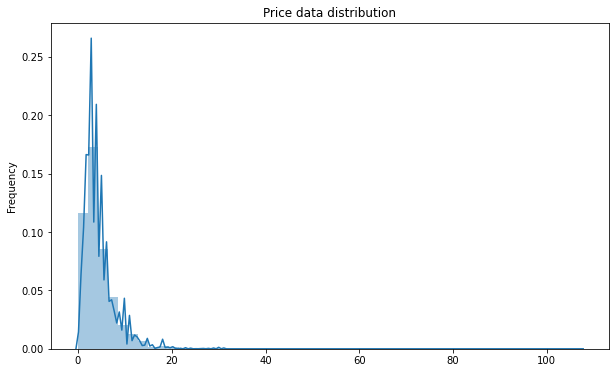

In [107]:
# check the distribution of prices

cur.execute("select sell_price from sell_price")
plt.figure(figsize=(10,6))
sns.distplot(cur.fetchall())
plt.title("Price data distribution")
plt.ylabel("Frequency");

In [64]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

- Distribution of Sales Between different Stores

In [108]:
# plt.style.use('seaborn-v0_8-darkgrid')  # Setting the style for the plots

# # Categorical Feature Distribution: 'store_id'
# plt.figure(figsize=(10, 6))
# sns.countplot(data=price, x='store_id')
# plt.title('Distribution of Sales Across Stores')
# plt.xlabel('Store ID')
# plt.ylabel('Number of Sales')
# plt.xticks(rotation=45)
# plt.show()

- Average Selling price over time by year

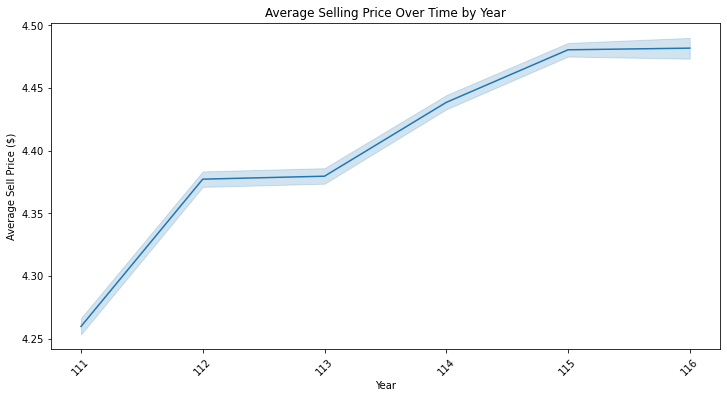

In [109]:
# Feature Selection
price['year'] = price['wm_yr_wk'] // 100
price['week'] = price['wm_yr_wk'] % 100
# Price Trend Analysis: Average selling price over time by year
plt.figure(figsize=(12, 6))
sns.lineplot(data=price, x='year', y='sell_price', estimator='mean')
plt.title('Average Selling Price Over Time by Year')
plt.xlabel('Year')
plt.ylabel('Average Sell Price ($)')
plt.xticks(rotation=45)
plt.show()

In [110]:
# average of price by store

cur.execute("select store_id, avg(sell_price) from sell_price group by store_id")
cur.fetchall()

[('CA_1', 4.414232816724471),
 ('CA_2', 4.445500262778929),
 ('CA_3', 4.388228821732322),
 ('CA_4', 4.42157973564122),
 ('TX_1', 4.374568974378535),
 ('TX_2', 4.366766279615124),
 ('TX_3', 4.387365173798334),
 ('WI_1', 4.457711709646401),
 ('WI_2', 4.4417170300627005),
 ('WI_3', 4.418116619298259)]

- Box plot for each Store with sell price

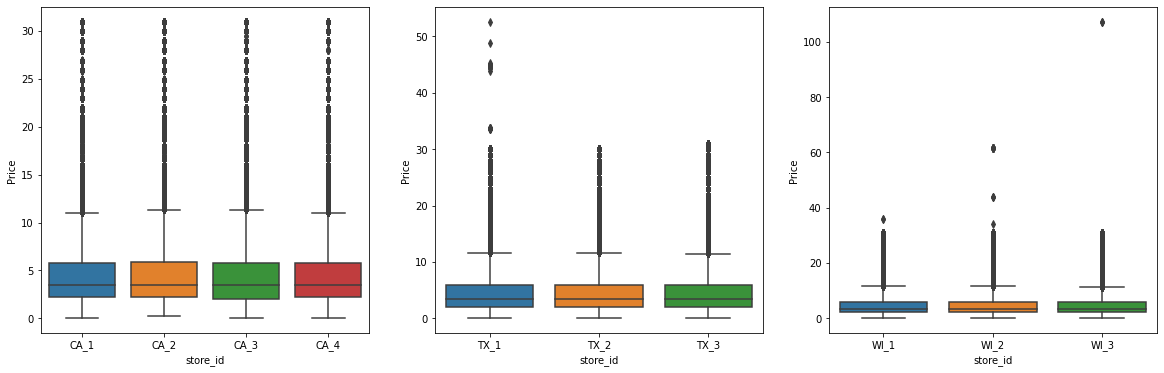

In [111]:
# draw box plot

cur.execute("select * from sell_price where store_id like 'CA%'")

store_df = []
store_df.append(pd.read_sql_query("select * from sell_price where store_id like 'CA%'",conn))
store_df.append(pd.read_sql_query("select * from sell_price where store_id like 'TX%'",conn))
store_df.append(pd.read_sql_query("select * from sell_price where store_id like 'WI%'",conn))

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(len(store_df)):
    sns.boxplot(x="store_id", y="sell_price", data=store_df[i], ax=ax[i])
    ax[i].set_ylabel("Price")

#### 1.2.3 Training Data Analysis

In [112]:
# analyze of train data

print('-'*30, 'Item_Id','-'*30 )
print("Item Id count {}".format(len(train['item_id'].unique())))
print(train['item_id'].unique())

print("-"*30, "dept_id", "-"*30)
print("dept_id values:{}".format(len(train["dept_id"].unique())))
print(train["store_id"].unique())

print("-"*30, "cat_id", "-"*30)
print("cat_id values:{}".format(len(train["cat_id"].unique())))
print(train["cat_id"].unique())

print("-"*30, "state_id", "-"*30)
print("state_id values:{}".format(len(train["state_id"].unique())))
print(train["state_id"].unique())

------------------------------ Item_Id ------------------------------
Item Id count 3049
['HOBBIES_1_001' 'HOBBIES_1_002' 'HOBBIES_1_003' ... 'FOODS_3_825'
 'FOODS_3_826' 'FOODS_3_827']
------------------------------ dept_id ------------------------------
dept_id values:7
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
------------------------------ cat_id ------------------------------
cat_id values:3
['HOBBIES' 'HOUSEHOLD' 'FOODS']
------------------------------ state_id ------------------------------
state_id values:3
['CA' 'TX' 'WI']


## Explore correlation between Macro data vs sales

In [113]:
# Merge Macro raw df with Walmart sales df
macro_data_daily.index =pd.to_datetime(macro_data_daily.index)
macro_data_pct_change_daily.index =pd.to_datetime(macro_data_pct_change_daily.index)
state_group_1 = train.groupby("state_id").sum(numeric_only=True).T
state_group_2 = pd.merge(state_group_1, calendar, left_index=True, right_on="d", how="left").set_index("Date_dt")
state_group_macro = pd.merge(left=state_group_2, left_index=True,
                  right=macro_data_daily, right_index=True,
                  how='left')
state_group_macro_pctchange = pd.merge(left=state_group_macro, left_index=True,
                  right=macro_data_pct_change_daily, right_index=True,
                  how='left')

In [117]:
# Explore correlation with raw macro data
expore_correl_df = state_group_macro.iloc[:,[0,1,2,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12]]
expore_correl_df.apply(pd.to_numeric, errors='ignore').corr()

,CA,TX,WI,"United States, New Home Sales, Sales price, average, Current Prices","United States, CPI, Fuel oil & other fuels, U.S. city average, Price Index","United States, University of Michigan, Consumer Sentiment Index, Volume Index","United States, Consumer price index, CPI, All items, Price Index","United States, House Prices, S&P Case-Shiller, National, Price Index","United States, National, Housing Affordability Index, composite, Price Index","United States, Disposable Personal Income, Per capita, Constant Prices","United States, Employment, Total (civilian, household survey), Volume","United States, CPI, Consumer dollar's purchasing power, U.S. city average, Price Index","United States, Personal Consumption Expenditure, Durable Goods, Current Prices","United States, Motor Vehicles, Car sales, domestic passenger, Volume","United States, NAHB/Wells Fargo Housing Market Index, single-family sales, Price Index"
CA,1.000000,0.902131,0.809589,0.436010,-0.317642,0.410653,0.513760,0.447111,-0.342536,0.307329,0.481728,-0.513742,0.471174,0.388102,0.494838
TX,0.902131,1.000000,0.779736,0.344181,-0.240423,0.347896,0.423623,0.332272,-0.211863,0.250405,0.386801,-0.426472,0.374217,0.336763,0.406358
WI,0.809589,0.779736,1.000000,0.571389,-0.439998,0.544029,0.554738,0.578068,-0.301027,0.464854,0.623587,-0.556045,0.601818,0.328106,0.633300
"United States, New Home Sales, Sales price, average, Current Prices",0.436010,0.344181,0.571389,1.000000,-0.580381,0.814910,0.837081,0.926599,-0.632200,0.649564,0.903988,-0.833030,0.902159,0.479385,0.907592
"United States, CPI, Fuel oil & other fuels, U.S. city average, Price Index",-0.317642,-0.240423,-0.439998,-0.580381,1.000000,-0.659934,-0.403322,-0.704204,0.429940,-0.825698,-0.757452,0.393844,-0.756311,-0.192305,-0.560320
"United States, University of Michigan, Consumer Sentiment Index, Volume Index",0.410653,0.347896,0.544029,0.814910,-0.659934,1.000000,0.706609,0.843035,-0.509912,0.755465,0.882080,-0.697522,0.869847,0.495920,0.824047
"United States, Consumer price index, CPI, All items, Price Index",0.513760,0.423623,0.554738,0.837081,-0.403322,0.706609,1.000000,0.828923,-0.665866,0.529172,0.842552,-0.999158,0.841474,0.665648,0.867288
"United States, House Prices, S&P Case-Shiller, National, Price Index",0.447111,0.332272,0.578068,0.926599,-0.704204,0.843035,0.828923,1.000000,-0.732537,0.741547,0.959314,-0.821019,0.959458,0.448075,0.893016
"United States, National, Housing Affordability Index, composite, Price Index",-0.342536,-0.211863,-0.301027,-0.632200,0.429940,-0.509912,-0.665866,-0.732537,1.000000,-0.362048,-0.588788,0.655916,-0.597974,-0.418091,-0.564392
"United States, Disposable Personal Income, Per capita, Constant Prices",0.307329,0.250405,0.464854,0.649564,-0.825698,0.755465,0.529172,0.741547,-0.362048,1.000000,0.835213,-0.519008,0.827105,0.305232,0.615111


In [115]:
# Explore correlation with pct_change macro data
expore_correl_df_pctchange = state_group_macro_pctchange.iloc[:,[0,1,2,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12]]
expore_correl_df_pctchange.apply(pd.to_numeric, errors='ignore').corr()

,CA,TX,WI,"United States, New Home Sales, Sales price, average, Current Prices_pctchange","United States, CPI, Fuel oil & other fuels, U.S. city average, Price Index_pctchange","United States, University of Michigan, Consumer Sentiment Index, Volume Index_pctchange","United States, Consumer price index, CPI, All items, Price Index_pctchange","United States, House Prices, S&P Case-Shiller, National, Price Index_pctchange","United States, National, Housing Affordability Index, composite, Price Index_pctchange","United States, Disposable Personal Income, Per capita, Constant Prices_pctchange","United States, Employment, Total (civilian, household survey), Volume_pctchange","United States, CPI, Consumer dollar's purchasing power, U.S. city average, Price Index_pctchange","United States, Personal Consumption Expenditure, Durable Goods, Current Prices_pctchange","United States, Motor Vehicles, Car sales, domestic passenger, Volume_pctchange","United States, NAHB/Wells Fargo Housing Market Index, single-family sales, Price Index_pctchange"
CA,1.000000,0.902131,0.809589,0.040651,-0.182748,-0.002282,-0.071569,0.322650,-0.067494,-0.000343,0.036654,0.065574,-0.013271,-0.025535,-0.027323
TX,0.902131,1.000000,0.779736,0.025559,-0.166866,-0.008586,-0.040367,0.330674,-0.061383,-0.046017,0.016242,0.031591,0.023504,-0.040245,-0.005491
WI,0.809589,0.779736,1.000000,0.017789,-0.174970,0.004158,-0.167676,0.356775,0.034398,-0.023723,0.055052,0.162930,-0.005497,-0.037836,-0.087168
"United States, New Home Sales, Sales price, average, Current Prices_pctchange",0.040651,0.025559,0.017789,1.000000,0.037193,-0.126122,-0.054224,0.130157,0.001025,-0.033942,-0.083846,0.070184,0.004213,-0.042081,-0.175415
"United States, CPI, Fuel oil & other fuels, U.S. city average, Price Index_pctchange",-0.182748,-0.166866,-0.174970,0.037193,1.000000,-0.000592,0.380442,-0.130711,0.182187,-0.093626,-0.084216,-0.364068,0.014467,0.144030,-0.009830
"United States, University of Michigan, Consumer Sentiment Index, Volume Index_pctchange",-0.002282,-0.008586,0.004158,-0.126122,-0.000592,1.000000,-0.050978,-0.050829,0.056848,-0.037522,0.243411,0.061583,-0.103705,-0.104294,0.174547
"United States, Consumer price index, CPI, All items, Price Index_pctchange",-0.071569,-0.040367,-0.167676,-0.054224,0.380442,-0.050978,1.000000,-0.114705,-0.294405,-0.198059,0.020804,-0.975759,-0.004258,0.286514,-0.164588
"United States, House Prices, S&P Case-Shiller, National, Price Index_pctchange",0.322650,0.330674,0.356775,0.130157,-0.130711,-0.050829,-0.114705,1.000000,-0.277874,-0.080443,-0.137341,0.109301,-0.169081,-0.132395,-0.226677
"United States, National, Housing Affordability Index, composite, Price Index_pctchange",-0.067494,-0.061383,0.034398,0.001025,0.182187,0.056848,-0.294405,-0.277874,1.000000,-0.034837,0.163533,0.301014,0.181464,-0.322485,0.165625
"United States, Disposable Personal Income, Per capita, Constant Prices_pctchange",-0.000343,-0.046017,-0.023723,-0.033942,-0.093626,-0.037522,-0.198059,-0.080443,-0.034837,1.000000,0.147309,0.254529,0.012964,0.152150,0.032576


#### 1.2.4 Time Series Data Analysis by each state and number of selling

- Visualization of sales volume after rolling about 28days

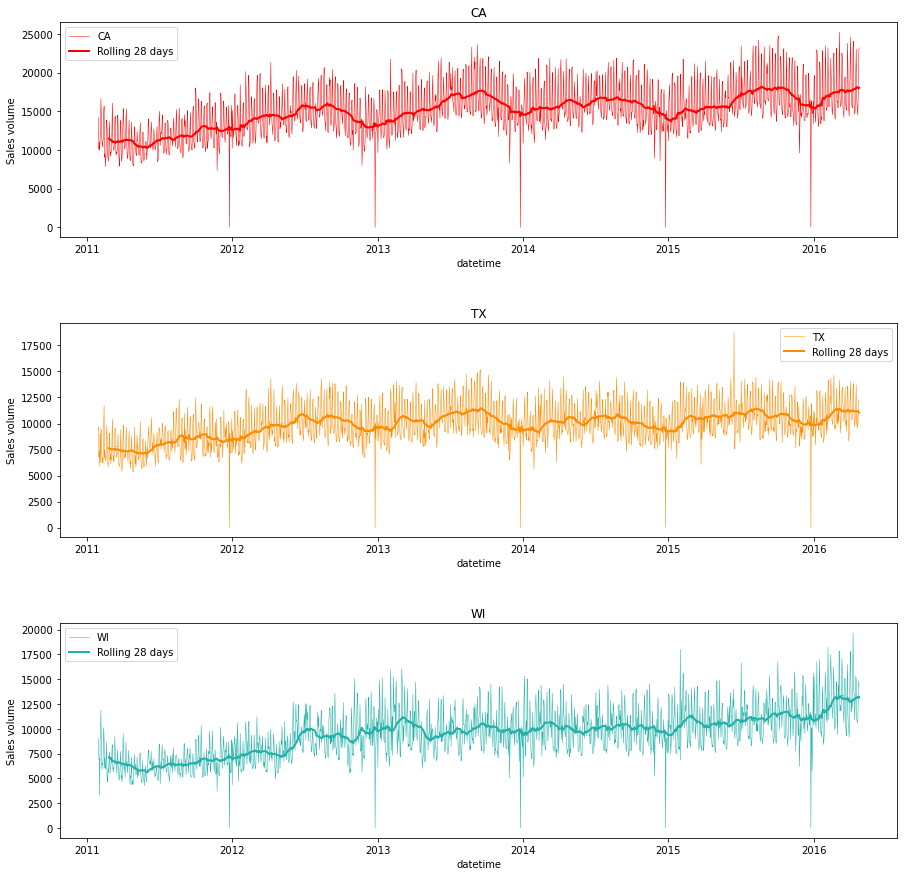

In [102]:
# Visualization
fig, ax = plt.subplots(3,1, figsize=(15,15))
plt.subplots_adjust(hspace=0.4)

color=["red", "darkorange", "lightseagreen"]
state_col = train["state_id"].unique()

for i in range(len(state_col)):
    ax[i].plot(state_group.index, state_group[state_col[i]], color=color[i], linewidth=0.5)
    # Rolling
    ax[i].plot(state_group.index, state_group[state_col[i]].rolling(28).mean(), color=color[i], linewidth=2)
    ax[i].set_xlabel("datetime")
    ax[i].set_ylabel("Sales volume")
    ax[i].legend(["{}".format(state_col[i]), "Rolling 28 days"])
    ax[i].set_title("{}".format(state_col[i]))

- Visualization of sales volume per year

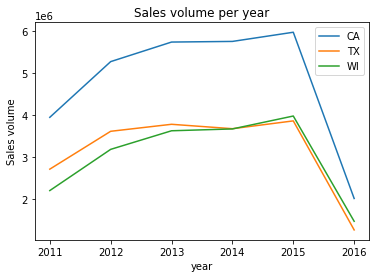

In [103]:
# Sales volume per year
state_group.groupby('year')[['CA', 'TX', 'WI']].sum().plot()
plt.title("Sales volume per year")
plt.ylabel("Sales volume");

#### 1.2.5 Data Components Decomposition and Autocorrelation for each state

In [104]:
# Chrismas Date during these years
#Xmas_date = [pd.datetime(2011,12,25), pd.datetime(2012,12,25), pd.datetime(2013,12,25), pd.datetime(2014,12,25), pd.datetime(2015,12,25)]
Xmas_date = [pd.Timestamp('2011-12-25'), pd.Timestamp('2012-12-25'), pd.Timestamp('2013-12-25'), pd.Timestamp('2014-12-25'), pd.Timestamp('2015-12-25')]

# Drop Xmas
state_group.drop(Xmas_date, inplace=True)

In [105]:
# store new data in SQL
r = cur.execute('''DROP TABLE IF EXISTS state_group''')
conn.commit()
state_group.to_sql(name='state_group', con=conn,if_exists='append',index=False)

1908

In [106]:
# Define time series analysis function
def plot_ts_decomp(base,col, lag, color):
    print("Analised Data:{}".format(col.upper()))
    # Stats model
    data=pd.read_sql_query("SELECT date, "+ col +" from " + base ,conn).set_index('date')
    data.index=pd.to_datetime(data.index)
    res = sm.tsa.seasonal_decompose(data[col], period=lag)
    data["trend"] = res.trend
    data["seaso"] = res.seasonal
    data["resid"] = res.resid

    # Visualization
    fig = plt.figure(figsize=(20,15))
    grid = plt.GridSpec(4,2, hspace=0.4, wspace=0.2)
    ax1 = fig.add_subplot(grid[0,0])
    ax2 = fig.add_subplot(grid[1,0])
    ax3 = fig.add_subplot(grid[2,0])
    ax4 = fig.add_subplot(grid[3,0])
    ax5 = fig.add_subplot(grid[:-2,1])
    ax6 = fig.add_subplot(grid[2:,1])

    # raw price data
    ax1.plot(data.index, data[col], label="price of {}".format(col), color=color, linewidth=0.5)
    ax1.plot(data.index, data[col].rolling(lag//12).mean(), label="Rolling {}".format(lag//12), color=color, linewidth=2)
    ax1.set_xlabel("date")
    ax1.set_ylabel("price")
    ax1.set_title("raw data")
    ax1.legend()
    # trend
    ax2.plot(data.index, data["trend"], label="trend of {}".format(col), color=color, linewidth=3)
    ax2.set_xlabel("date")
    ax2.set_ylabel("trend")
    ax2.set_title("trend")
    ax2.legend()
    # seasonaly
    ax3.plot(data.index, data["seaso"], label="seasonaly of {}".format(col), color=color, linewidth=0.5)
    ax3.set_xlabel("date")
    ax3.set_ylabel("seasonaly")
    ax3.set_title("seasonaly")
    ax3.legend()
    # residual
    ax4.plot(data.index, data["resid"], label="residual error of {}".format(col), color=color, linewidth=0.5)
    ax4.set_xlabel("date")
    ax4.set_ylabel("residual error")
    ax4.set_title("residual")
    ax4.legend()
    # distribution
    sns.distplot(data[col], ax=ax5)
    ax5.set_xlabel("Price")
    ax5.set_ylabel("Frequency")
    ax5.set_title("distribution")
    # auto correlation
    autocorrelation_plot(data[col], ax=ax6, linewidth=0.5)
    ax6.set_title("autocorrelation")

Analised Data:CA


C:\Users\jermyndaebak\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


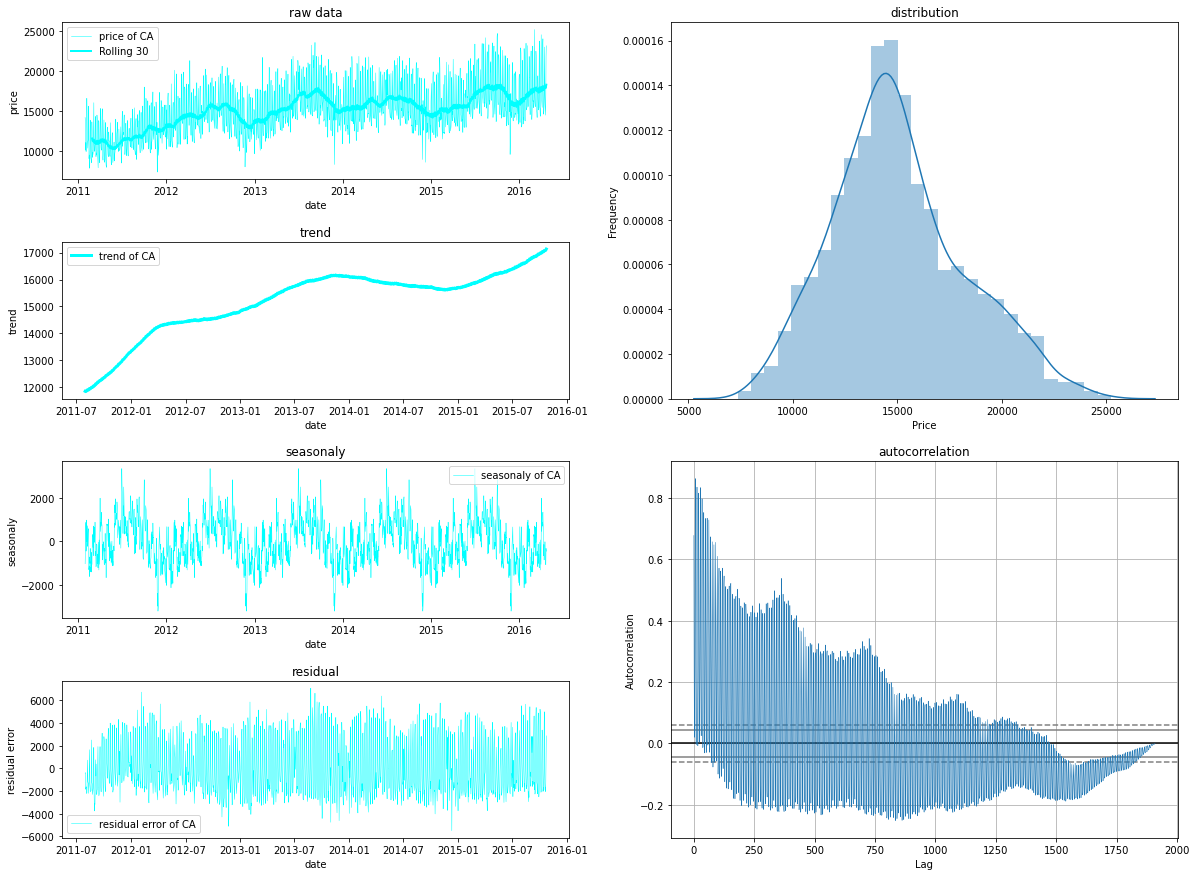

In [107]:
# CA of state
plot_ts_decomp("state_group", "CA", 365, "aqua");

Analised Data:TX


C:\Users\jermyndaebak\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


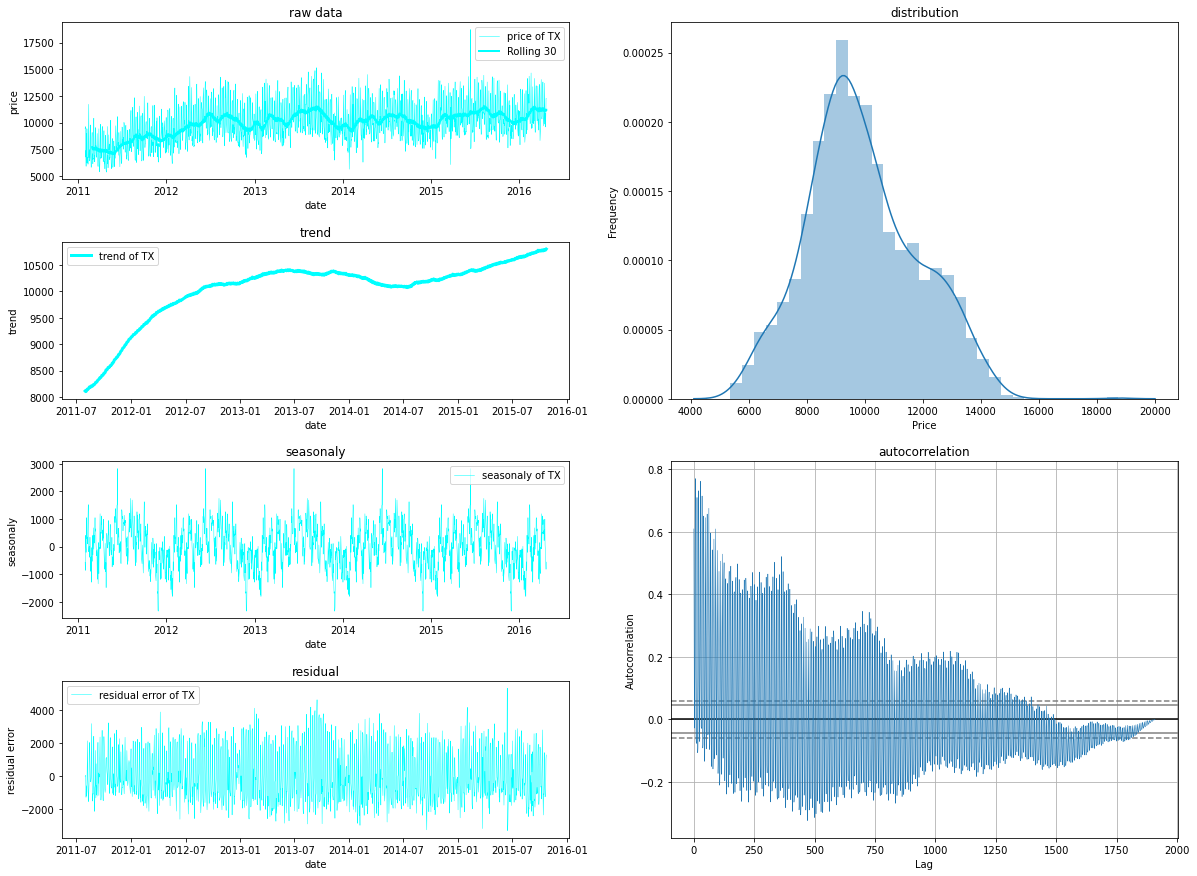

In [108]:
# TX of state
plot_ts_decomp("state_group", "TX", 365, "aqua");

Analised Data:WI


C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


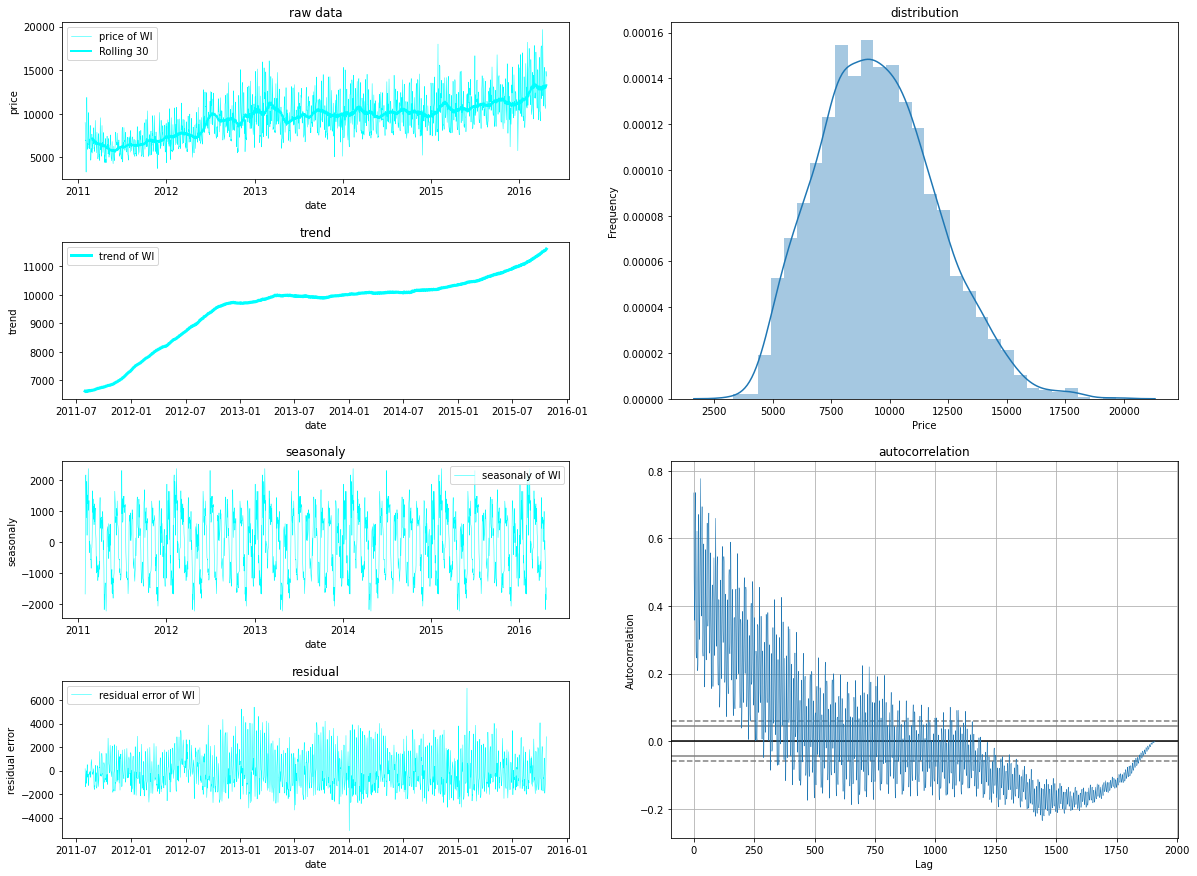

In [37]:
# WI of state
plot_ts_decomp("state_group", "WI", 365, "aqua");

#### 1.2.6 Time Series Data Analysis by each category and number of selling

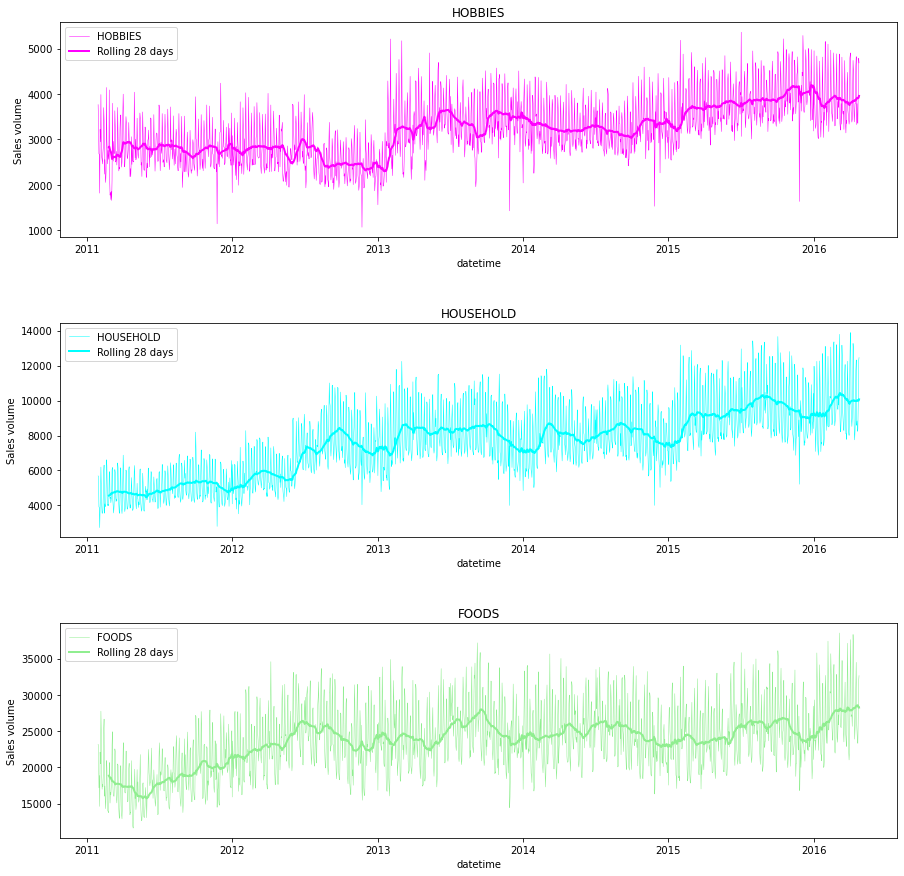

In [109]:
# Create dataframe by grouping
cate_group = train.groupby("cat_id").sum().T
cate_group = pd.merge(cate_group, calendar, left_index=True, right_on="d", how="left").set_index("Date_dt")

# Drop chrismas
cate_group.drop(Xmas_date, inplace=True)

# Visualization
fig, ax = plt.subplots(3,1, figsize=(15,15))
plt.subplots_adjust(hspace=0.4)

color=["magenta", "cyan", "lightgreen"]
cate_col = train["cat_id"].unique()

for i in range(len(cate_col)):
    ax[i].plot(cate_group.index, cate_group[cate_col[i]], color=color[i], linewidth=0.5)
    # Rolling
    ax[i].plot(cate_group.index, cate_group[cate_col[i]].rolling(28).mean(), color=color[i], linewidth=2)
    ax[i].set_xlabel("datetime")
    ax[i].set_ylabel("Sales volume")
    ax[i].legend(["{}".format(cate_col[i]), "Rolling 28 days"])
    ax[i].set_title("{}".format(cate_col[i]))

C:\Users\zhouw\AppData\Local\Temp/ipykernel_3100/1749821103.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cate_group.groupby("year")['FOODS', 'HOBBIES', 'HOUSEHOLD'].sum().plot()


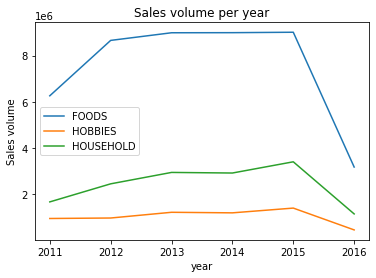

In [39]:
# Sales volume per year
cate_group.groupby("year")['FOODS', 'HOBBIES', 'HOUSEHOLD'].sum().plot()
plt.title("Sales volume per year")
plt.ylabel("Sales volume");

#### 1.2.7 Data Components Decomposition and Autocorrelation for each category

In [40]:
# store new data in SQL
r = cur.execute('''DROP TABLE IF EXISTS cate_group''')
conn.commit()
cate_group.to_sql(name='cate_group', con=conn,if_exists='append',index=False)

Analised Data:HOBBIES


C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


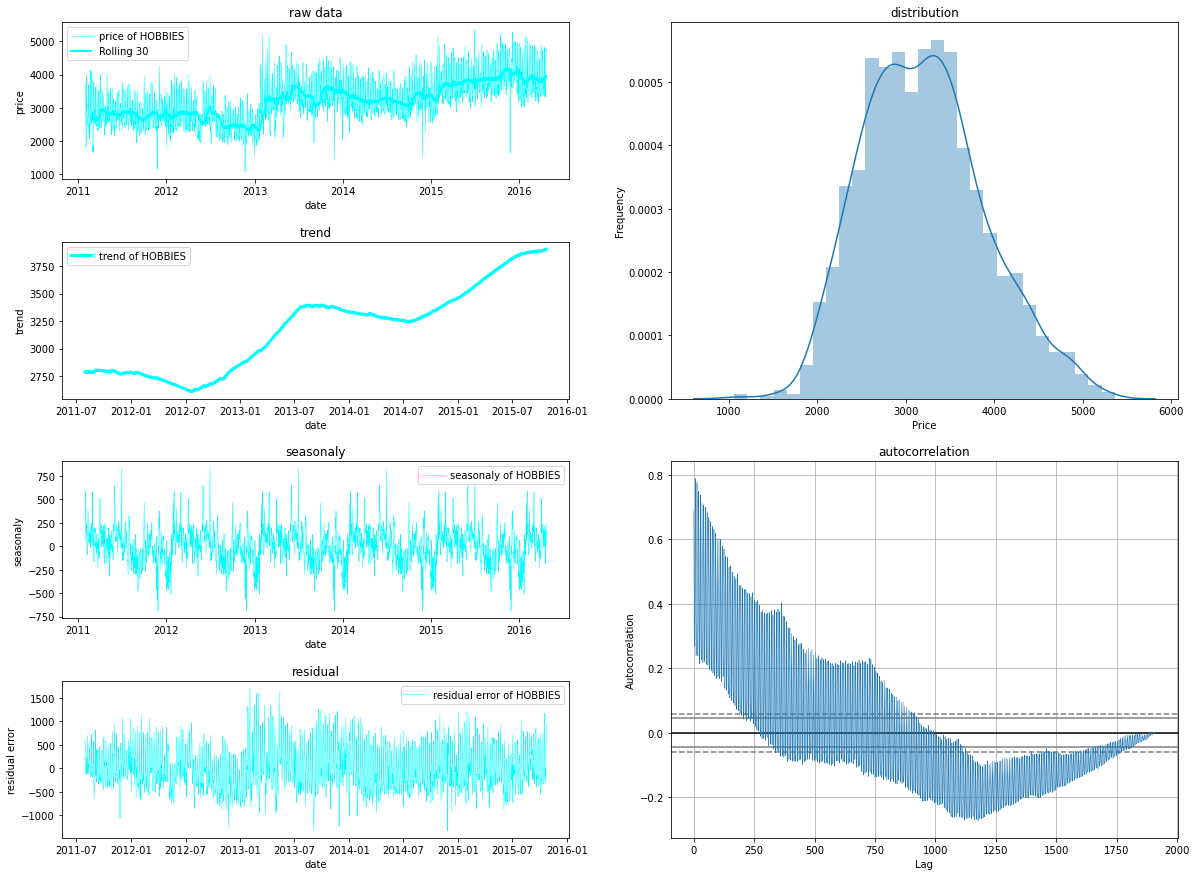

In [41]:
# HOBBIES of cat
plot_ts_decomp("cate_group", "HOBBIES", 365, "aqua");

Analised Data:HOUSEHOLD


C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


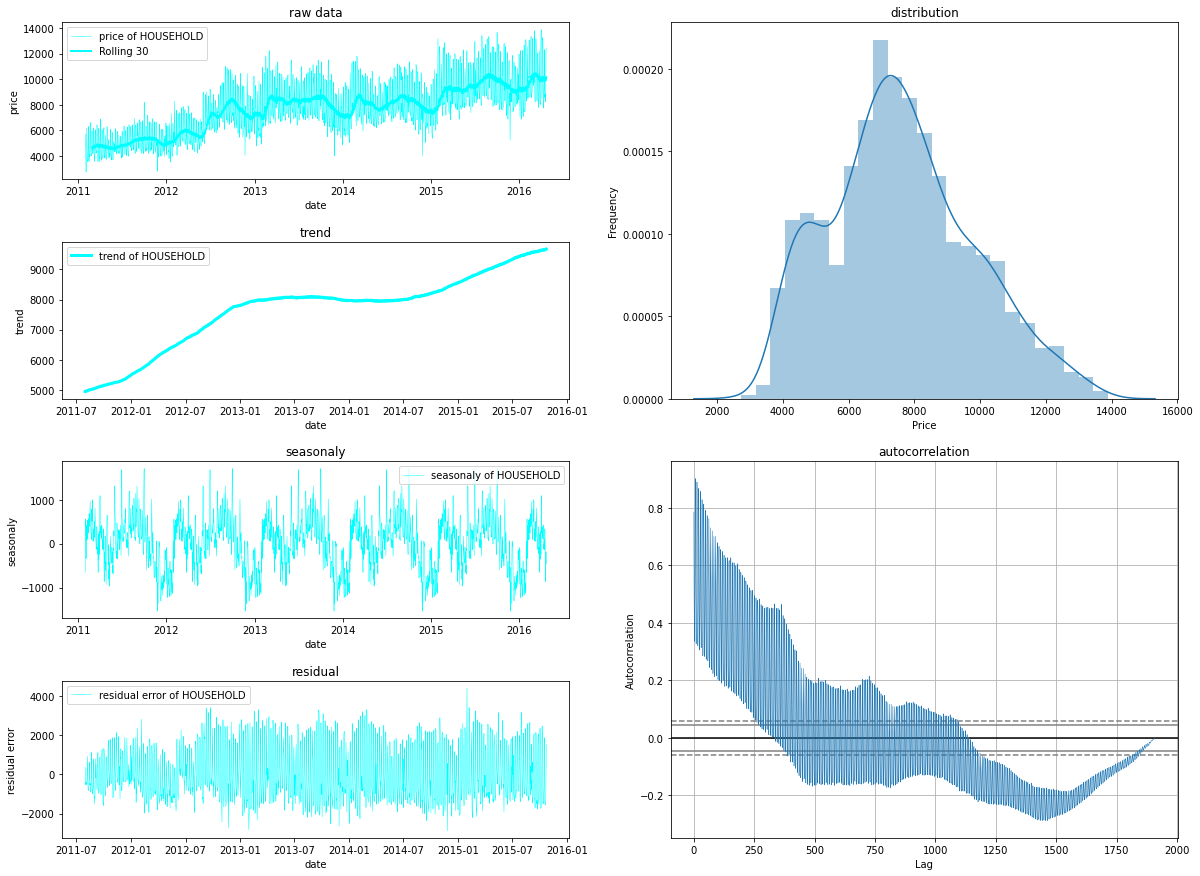

In [42]:
# HOUSEHOLD of cat
plot_ts_decomp("cate_group", "HOUSEHOLD", 365, "aqua");

Analised Data:FOODS


C:\Users\zhouw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


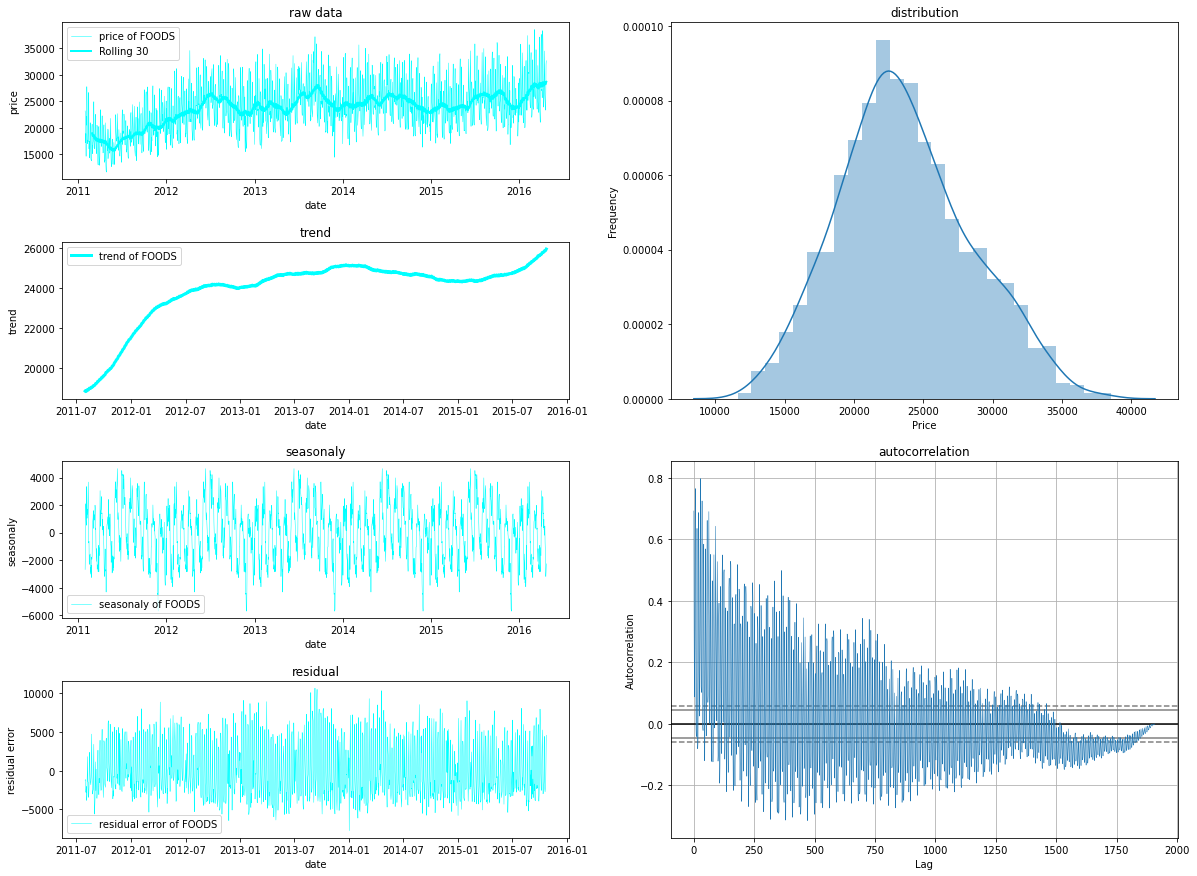

In [43]:
# FOODS of cat
plot_ts_decomp("cate_group", "FOODS", 365, "aqua");

## 2. Prediction sales for Walmart with LGBM Model

In [165]:
# Define function
def lag_featrues(df,df_macro):
    out_df = df[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']    
    out_df['United States, Personal Consumption Expenditure, Durable Goods, Current Prices'] = df_macro.loc[:,'United States, Personal Consumption Expenditure, Durable Goods, Current Prices']
    display(out_df)
    ###############################################################################
    # day lag 29~57 day and last year's day lag 1~28 day
    day_lag = df.iloc[:,-28:]
    day_year_lag = df.iloc[:,-393:-365]
    day_lag.columns = [str("lag_{}_day".format(i)) for i in range(29,57)] # Rename columns
    day_year_lag.columns = [str("lag_{}_day_of_last_year".format(i)) for i in range(1,29)]

    # Rolling mean(3) and (7) and (28) and (84) 29~57 day and last year's day lag 1~28 day
    rolling_3 = df.iloc[:,-730:].T.rolling(3).mean(numeric_only=True).T.iloc[:,-28:]
    rolling_3.columns = [str("rolling3_lag_{}_day".format(i)) for i in range(29,57)] # Rename columns
    rolling_3_year = df.iloc[:,-730:].T.rolling(3).mean(numeric_only=True).T.iloc[:,-393:-365]
    rolling_3_year.columns = [str("rolling3_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]

    rolling_7 = df.iloc[:,-730:].T.rolling(7).mean(numeric_only=True).T.iloc[:,-28:]
    rolling_7.columns = [str("rolling7_lag_{}_day".format(i)) for i in range(29,57)] # Rename columns
    rolling_7_year = df.iloc[:,-730:].T.rolling(7).mean(numeric_only=True).T.iloc[:,-393:-365]
    rolling_7_year.columns = [str("rolling7_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]

    rolling_28 = df.iloc[:,-730:].T.rolling(28).mean(numeric_only=True).T.iloc[:,-28:]
    rolling_28.columns = [str("rolling28_lag_{}_day".format(i)) for i in range(29,57)]
    rolling_28_year = df.iloc[:,-730:].T.rolling(28).mean(numeric_only=True).T.iloc[:,-393:-365]
    rolling_28_year.columns = [str("rolling28_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]

    rolling_84 = df.iloc[:,-730:].T.rolling(84).mean(numeric_only=True).T.iloc[:,-28:]
    rolling_84.columns = [str("rolling84_lag_{}_day".format(i)) for i in range(29,57)]
    rolling_84_year = df.iloc[:,-730:].T.rolling(84).mean(numeric_only=True).T.iloc[:,-393:-365]
    rolling_84_year.columns = [str("rolling84_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]

    # monthly lag 1~18 month
    month_lag = pd.DataFrame({})
    for i in range(1,19):
        if i == 1:
            monthly = df.iloc[:,-28*i:].T.sum(numeric_only=True).T
            month_lag["monthly_lag_{}_month".format(i)] = monthly
        else:
            monthly = df.iloc[:, -28*i:-28*(i-1)].T.sum(numeric_only=True).T
            month_lag["monthly_lag_{}_month".format(i)] = monthly

    # combine day lag and monthly lag
    out_df = pd.concat([out_df, day_lag], axis=1)
    out_df = pd.concat([out_df, day_year_lag], axis=1)
    out_df = pd.concat([out_df, rolling_3], axis=1)
    out_df = pd.concat([out_df, rolling_3_year], axis=1)
    out_df = pd.concat([out_df, rolling_7], axis=1)
    out_df = pd.concat([out_df, rolling_7_year], axis=1)
    out_df = pd.concat([out_df, rolling_28], axis=1)
    out_df = pd.concat([out_df, rolling_28_year], axis=1)
    out_df = pd.concat([out_df, rolling_84], axis=1)
    out_df = pd.concat([out_df, rolling_84_year], axis=1)
    out_df = pd.concat([out_df, month_lag], axis=1)

    ###############################################################################
    # dept_id
    group_dept = df.groupby("dept_id").sum(numeric_only=True)
    # day lag 29~57 day and last year's day lag 1~28 day
    dept_day_lag = group_dept.iloc[:,-28:]
    dept_day_year_lag = group_dept.iloc[:,-393:-365]
    dept_day_lag.columns = [str("dept_lag_{}_day".format(i)) for i in range(29,57)]
    dept_day_year_lag.columns = [str("dept_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    # monthly lag 1~18 month
    month_dept_lag = pd.DataFrame({})
    for i in range(1,19):
        if i == 1:
            monthly_dept = group_dept.iloc[:,-28*i:].T.sum().T
            month_dept_lag["dept_monthly_lag_{}_month".format(i)] = monthly_dept
        elif i >= 7 and i < 13:
            continue
        else:
            monthly = group_dept.iloc[:, -28*i:-28*(i-1)].T.sum().T
            month_dept_lag["dept_monthly_lag_{}_month".format(i)] = monthly_dept
    # combine out df
    out_df = pd.merge(out_df, dept_day_lag, left_on="dept_id", right_index=True, how="left")
    out_df = pd.merge(out_df, dept_day_year_lag, left_on="dept_id", right_index=True, how="left")
    out_df = pd.merge(out_df, month_dept_lag, left_on="dept_id", right_index=True, how="left")

    ###############################################################################
    # cat_id
    group_cat = df.groupby("cat_id").sum(numeric_only=True)
    # day lag 29~57 day and last year's day lag 1~28 day
    cat_day_lag = group_cat.iloc[:,-28:]
    cat_day_year_lag = group_cat.iloc[:,-393:-365]
    cat_day_lag.columns = [str("cat_lag_{}_day".format(i)) for i in range(29,57)]
    cat_day_year_lag.columns = [str("cat_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    # monthly lag 1~18 month
    month_cat_lag = pd.DataFrame({})
    for i in range(1,19):
        if i == 1:
            monthly_cat = group_cat.iloc[:,-28*i:].T.sum().T
            month_cat_lag["cat_monthly_lag_{}_month".format(i)] = monthly_cat
        elif i >= 7 and i < 13:
            continue
        else:
            monthly_cat = group_cat.iloc[:, -28*i:-28*(i-1)].T.sum().T
            month_cat_lag["dept_monthly_lag_{}_month".format(i)] = monthly_cat

    # combine out df
    out_df = pd.merge(out_df, cat_day_lag, left_on="cat_id", right_index=True, how="left")
    out_df = pd.merge(out_df, cat_day_year_lag, left_on="cat_id", right_index=True, how="left")
    out_df = pd.merge(out_df, month_cat_lag, left_on="cat_id", right_index=True, how="left")

    ###############################################################################
    # store_id
    group_store = df.groupby("store_id").sum(numeric_only=True)
    # day lag 29~57 day and last year's day lag 1~28 day
    store_day_lag = group_store.iloc[:,-28:]
    store_day_year_lag = group_store.iloc[:,-393:-365]
    store_day_lag.columns = [str("store_lag_{}_day".format(i)) for i in range(29,57)]
    store_day_year_lag.columns = [str("store_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    # monthly lag 1~18 month
    month_store_lag = pd.DataFrame({})
    for i in range(1,19):
        if i == 1:
            monthly_store = group_store.iloc[:,-28*i:].T.sum().T
            month_store_lag["store_monthly_lag_{}_month".format(i)] = monthly_store
        elif i >= 7 and i <13:
            continue
        else:
            monthly_store = group_store.iloc[:, -28*i:-28*(i-1)].T.sum().T
            month_store_lag["store_monthly_lag_{}_month".format(i)] = monthly_store

    # combine out df
    out_df = pd.merge(out_df, store_day_lag, left_on="store_id", right_index=True, how="left")
    out_df = pd.merge(out_df, store_day_year_lag, left_on="store_id", right_index=True, how="left")
    out_df = pd.merge(out_df, month_store_lag, left_on="store_id", right_index=True, how="left")

    ###############################################################################
    # state_id
    group_state = df.groupby("state_id").sum(numeric_only=True)
    # day lag 29~57 day and last year's day lag 1~28 day
    state_day_lag = group_state.iloc[:,-28:]
    state_day_year_lag = group_state.iloc[:,-393:-365]
    state_day_lag.columns = [str("state_lag_{}_day".format(i)) for i in range(29,57)]
    state_day_year_lag.columns = [str("state_lag_{}_day_of_last_year".format(i)) for i in range(1,29)]
    # monthly lag 1~18 month
    month_state_lag = pd.DataFrame({})
    for i in range(1,13):
        if i == 1:
            monthly_state = group_state.iloc[:,-28*i:].T.sum().T
            month_state_lag["state_monthly_lag_{}_month".format(i)] = monthly_state
        elif i >= 7 and i < 13:
            continue
        else:
            monthly_state = group_state.iloc[:, -28*i:-28*(i-1)].T.sum().T
            month_state_lag["state_monthly_lag_{}_month".format(i)] = monthly_state

    # combine out df
    out_df = pd.merge(out_df, state_day_lag, left_on="state_id", right_index=True, how="left")
    out_df = pd.merge(out_df, state_day_year_lag, left_on="state_id", right_index=True, how="left")
    out_df = pd.merge(out_df, month_state_lag, left_on="state_id", right_index=True, how="left")

    ###############################################################################
    # category flag
    col_list = ['dept_id', 'cat_id', 'store_id', 'state_id']

    df_cate_oh = pd.DataFrame({})
    for i in col_list:
        df_oh = pd.get_dummies(df[i])
        df_cate_oh = pd.concat([df_cate_oh, df_oh], axis=1)

    out_df = pd.concat([out_df, df_cate_oh], axis=1)

    return out_df

In [45]:
%%time
# Features
Train_data = train.iloc[:,:-56]
Val_data = train.iloc[:,:-28]

X_train = lag_featrues(Train_data).iloc[:,5:] # select variables
y_train = train.iloc[:,-56]
X_test = lag_featrues(Val_data).iloc[:,5:]
y_test = train.iloc[:,-28]

# Create instance
lgbm = lgb.LGBMRegressor()

# Training and score
learning_rate = [0.15, 0.2, 0.25]
max_depth = [15, 20, 25]

param_grid = {'learning_rate': learning_rate, 'max_depth': max_depth}

# Fitting
cv_lgbm = GridSearchCV(lgbm, param_grid, cv=10, n_jobs =1)
cv_lgbm.fit(X_train, y_train)

print("Best params:{}".format(cv_lgbm.best_params_))

# best params
best_lg = cv_lgbm.best_estimator_

# prediction
y_train_pred_lg = best_lg.predict(X_train)
y_test_pred_lg = best_lg.predict(X_test)

print("MSE train:{}".format(mean_squared_error(y_train, y_train_pred_lg)))
print("MSE test;{}".format(mean_squared_error(y_test, y_test_pred_lg)))

print("R2 score train:{}".format(r2_score(y_train, y_train_pred_lg)))
print("R2 score test:{}".format(r2_score(y_test, y_test_pred_lg)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51794
[LightGBM] [Info] Number of data points in the train set: 27441, number of used features: 586
[LightGBM] [Info] Start training from score 1.219416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [46]:
# Feature importance
importance = best_lg.feature_importances_

indices = np.argsort(importance)[::-1]

# print importance
importance_df = pd.DataFrame({})
columns = []
importance_ = []
for f in range(X_train.shape[1]):
    print("%2d) %-*s %.2f" %(f+1, 30, X_train.columns[indices[f]], importance[indices[f]]))
    col = X_train.columns[indices[f]]
    imp = importance[indices[f]]
    columns.append(col)
    importance_.append(imp)
importance_df["col_name"] = columns
importance_df["importance"] = importance_

 1) lag_44_day                     74.00
 2) rolling3_lag_56_day            65.00
 3) rolling7_lag_56_day            43.00
 4) lag_56_day                     40.00
 5) rolling3_lag_46_day            34.00
 6) rolling3_lag_33_day            33.00
 7) lag_32_day                     32.00
 8) lag_33_day                     32.00
 9) monthly_lag_10_month           30.00
10) rolling28_lag_56_day           29.00
11) lag_55_day                     29.00
12) lag_54_day                     29.00
13) rolling3_lag_51_day            28.00
14) monthly_lag_3_month            28.00
15) rolling3_lag_45_day            28.00
16) monthly_lag_8_month            26.00
17) lag_29_day                     25.00
18) monthly_lag_18_month           24.00
19) rolling3_lag_47_day            24.00
20) lag_34_day                     24.00
21) monthly_lag_7_month            24.00
22) rolling3_lag_44_day            23.00
23) lag_43_day                     23.00
24) rolling3_lag_52_day            23.00
25) monthly_lag_

Text(0.5, 1.0, 'Prediction data plot')

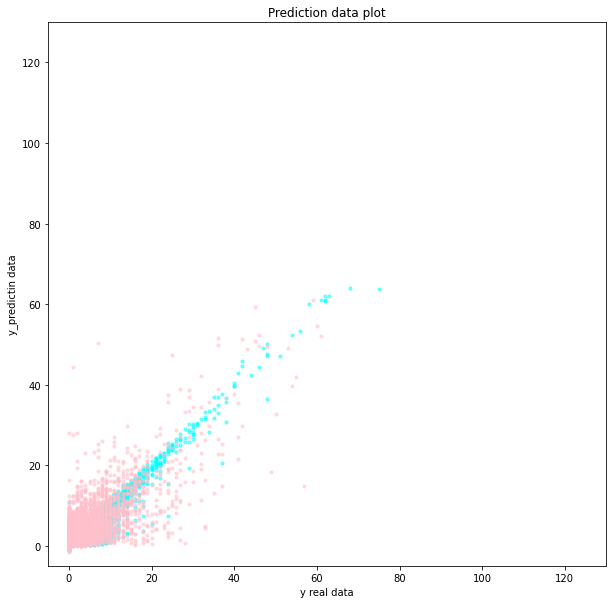

In [47]:
# Visualization of prediction and test data
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_train_pred_lg, s=10, color="aqua", label="train data prediction", alpha=0.5)
plt.scatter(y_test, y_test_pred_lg, s=10, color="pink", label="test data prediction",  alpha=0.5)
plt.xlabel("y real data")
plt.xlim([-5,130])
plt.ylim([-5,130])
plt.ylabel("y_predictin data")
plt.title("Prediction data plot")

In [48]:
#Predict using only variables with an importance of 1 or higher.

In [49]:
%%time
# importance columns (>0)
imp_col = importance_df[importance_df["importance"]>0]["col_name"].values

# Train test split, select by imp_col

X_train = lag_featrues(Train_data).iloc[:,5:][imp_col] # select variables
X_train['prediction'] = y_train_pred_lg
y_train = train.iloc[:,-56]
X_test = lag_featrues(Val_data).iloc[:,5:][imp_col]
X_test['prediction'] = y_test_pred_lg
y_test = train.iloc[:,-28]
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [10, 15, 20],
    'num_leaves': [31, 50, 100],
    'min_child_samples': [20, 30, 50],
}

# Fitting
cv_lgbm = RandomizedSearchCV(lgbm, param_grid, n_iter=100, cv=3, n_jobs=1, verbose=1, random_state=42)
cv_lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
# Create instance
lgbm = lgb.LGBMRegressor()

# # Training and score
# learning_rate = [0.15, 0.2, 0.25]
# max_depth = [15, 20, 25]

# param_grid = {'learning_rate': learning_rate, 'max_depth': max_depth}

# # Fitting
# cv_lgbm = GridSearchCV(lgbm, param_grid, cv=10, n_jobs =1)
# cv_lgbm.fit(X_train, y_train)

print("Best params:{}".format(cv_lgbm.best_params_))

# best params
best_lg = cv_lgbm.best_estimator_

# prediction
y_train_pred_lg = best_lg.predict(X_train)
y_test_pred_lg = best_lg.predict(X_test)

print("MSE train:{}".format(mean_squared_error(y_train, y_train_pred_lg)))
print("MSE test;{}".format(mean_squared_error(y_test, y_test_pred_lg)))

print("R2 score train:{}".format(r2_score(y_train, y_train_pred_lg)))
print("R2 score test:{}".format(r2_score(y_test, y_test_pred_lg)))

NameError: name 'RandomizedSearchCV' is not defined

In [50]:
# Assuming `best_lg` is your trained LightGBM model and `X_train` is the data used for training
train_features = X_train.columns.tolist()

# For the prediction, ensure that `X_test` has the same features
test_features = X_test.columns.tolist()

# Verify that the features match
print(set(train_features) == set(test_features))

# Check for any missing columns
print(set(train_features) - set(test_features))
print(set(test_features) - set(train_features))

# Make sure the columns are in the same order
X_test = X_test[train_features]


True
set()
set()


In [51]:
#Predict sales for next 2 month.

In [52]:
%%time
# Prediction last 28 days by roop

def lgbm_pred(X_train, y_train, X_test):
    lgbm = lgb.LGBMRegressor(learning_rate=0.2, max_depth=20)
    # Fitting
    lgbm.fit(X_train, y_train)
    # prediction
    y_pred = lgbm.predict(X_test)
    return y_pred

# Features
# Features
Train_data = train.iloc[:,:-56]
Y_train = train.iloc[:,-56:-28]
Val_data = train.iloc[:,:-28]
Y_test = train.iloc[:,-28:]

Pred_data = pd.DataFrame({})
for d in range(0,28):
    if d == 0:
        X_train = lag_featrues(Train_data).iloc[:,5:][imp_col] # select variables
        y_train = Y_train.iloc[:,d]
        X_test = lag_featrues(Val_data).iloc[:,5:][imp_col]

        # Train test split, select by imp_col
        pred = lgbm_pred(X_train, y_train, X_test)
        Pred_data["pred_{}_day".format(1+d)] = pred
    else:
        X_train = lag_featrues(Train_data.iloc[:,:-1])[imp_col]
        y_train = Y_train.iloc[:,d]
        X_test = lag_featrues(Train_data)[imp_col][imp_col]

        # Train test split, select by imp_col
        pred = lgbm_pred(X_train, y_train, X_test)
        Pred_data["pred_{}_day".format(1+d)] = pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45782
[LightGBM] [Info] Number of data points in the train set: 30490, number of used features: 313
[LightGBM] [Info] Start training from score 1.222007
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

Text(0, 0.5, 'R2 score')

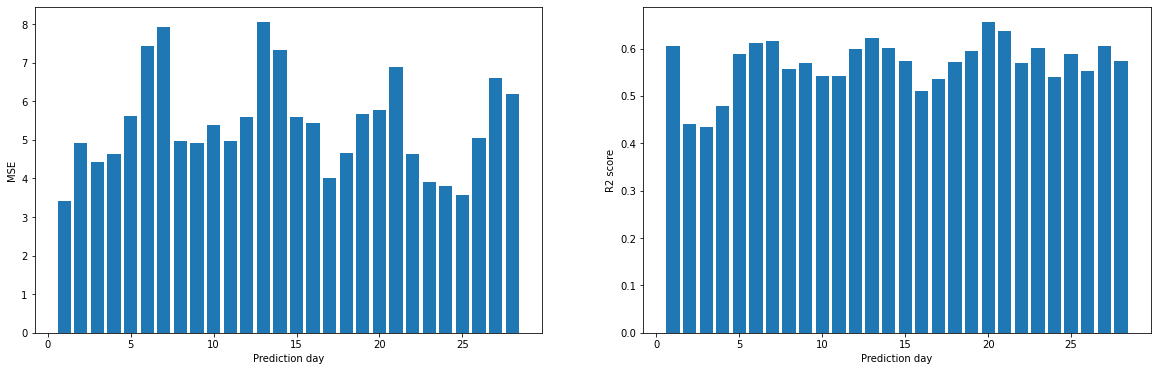

In [53]:
# Confirming prediction result
MSE = []
R2_score = []

for i in range(Y_test.shape[1]):
    mse = mean_squared_error(Y_test.iloc[:,i], Pred_data.iloc[:,i])
    r2 = r2_score(Y_test.iloc[:,i], Pred_data.iloc[:,i])
    MSE.append(mse)
    R2_score.append(r2)

month_pred_score = pd.DataFrame({"day":range(1,29),
                                 "MSE":MSE,
                                 "R2":R2_score})

# Visualization check
fig, ax = plt.subplots(1,2, figsize=(20, 6))

ax[0].bar(month_pred_score["day"], month_pred_score["MSE"])
ax[0].set_xlabel("Prediction day")
ax[0].set_ylabel("MSE")

ax[1].bar(month_pred_score["day"], month_pred_score["R2"])
ax[1].set_xlabel("Prediction day")
ax[1].set_ylabel("R2 score")

In [54]:
#Submission data prediction

In [55]:
%%time
# Prediction next 56 days by roop

# Features
Train_data = train.iloc[:,:-28]
Test_data = train
Y_train = train.iloc[:,-28:]

Pred_data_val = pd.DataFrame({})
Pred_data_eval = pd.DataFrame({})

for d in range(0,28):
    X_train = lag_featrues(Train_data)[imp_col] # select variables
    y_train = Y_train.iloc[:,d]
    X_test = lag_featrues(Test_data)[imp_col]

    # Train test split, select by imp_col
    pred = lgbm_pred(X_train, y_train, X_test)
    Pred_data_val["pred_{}_day".format(1+d)] = pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45487
[LightGBM] [Info] Number of data points in the train set: 30490, number of used features: 313
[LightGBM] [Info] Start training from score 1.182060
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

In [56]:
Train_data = train
Test_data = pd.concat([train, Pred_data_val], axis=1)
Y_train = Pred_data_val

for d in range(0,28):
    X_train = lag_featrues(Train_data)[imp_col]
    y_train = Y_train.iloc[:,d]
    X_test = lag_featrues(Test_data)[imp_col]

    # Train test split, select by imp_col
    pred = lgbm_pred(X_train, y_train, X_test)
    Pred_data_eval["pred_{}_day".format(1+d)] = pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45642
[LightGBM] [Info] Number of data points in the train set: 30490, number of used features: 313
[LightGBM] [Info] Start training from score 1.197150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't exp

In [57]:
Pred_data_val.columns = sample.loc[:,"F1":].columns
Pred_data_eval.columns = sample.loc[:,"F1":].columns

# concat val data and eval data
submit_data = pd.concat([Pred_data_val, Pred_data_eval])
submit_data = submit_data.reset_index().drop("index", axis=1)

col = sample.loc[:,'F1':].columns

sample[col] = submit_data

# Submission data
sample.to_csv("submission1.csv", index=False)

# Submission data
sample.round(0).to_csv("submission_r1.csv", index=False)